In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:

import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_tubingen_pairs_dataset, get_synthetic_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
x, y, weight = get_synthetic_dataset(
    num_datasets=100,
    sample_size=100,
    func_string="mult_a",
    noise="normal"
)
x = (x - x.mean(axis=1)[:, None, :]) / x.std(axis=1)[:, None, :]
y = (y - y.mean(axis=1)[:, None, :]) / y.std(axis=1)[:, None, :]
input, output = y[6], x[6]

In [4]:
x, y, weight = get_tubingen_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/pairs/files'
)
input, output = x[0], y[0]
input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]

Load cause-effect pairs: 100%|██████████| 100/100 [00:00<00:00, 164.50it/s]


In [5]:
tf.config.list_physical_devices('GPU')

2022-06-09 21:00:42.378335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 21:00:42.390988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 21:00:42.391274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

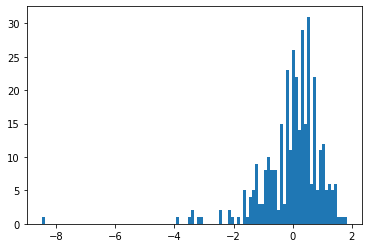

In [9]:
import matplotlib.pyplot as plt
import numpy as np


plt.hist(output[:, 0], bins=100)
plt.show()

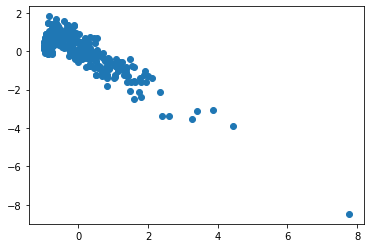

In [10]:
plt.scatter(input[:, 0], output[:, 0])
plt.show()

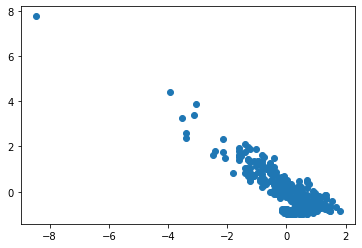

In [11]:
plt.scatter(output[:, 0], input[:, 0])
plt.show()

In [89]:
from gpflow.base import Parameter
from gpflow.utilities import positive




num_inducing = 349

kernel_variance = 10
kernel_lengthscale = 1. / 4
# likelihood_variance = 1
likelihood_variance = Parameter( 1. / (0.2 ** 2), transform=positive(lower=0.01))

sq_exp = gpflow.kernels.SquaredExponential()
sq_exp.variance.assign(kernel_variance)
    # lambda = 5 in this
sq_exp.lengthscales.assign(kernel_lengthscale)

m_gpr = gpflow.models.GPR(data=(input, output), kernel=sq_exp, mean_function=None)
m_gpr.likelihood.variance = likelihood_variance
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m_gpr.training_loss, m_gpr.trainable_variables, options=dict(maxiter=10000)
)

In [90]:
x_new = np.linspace(-10, 10, 1000)[:, None]
pred_f, var_f = m_gpr.predict_y(x_new)

In [91]:
from gpflow.utilities import print_summary
print_summary(m_gpr)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 12.8212   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  1.19102  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.177178 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

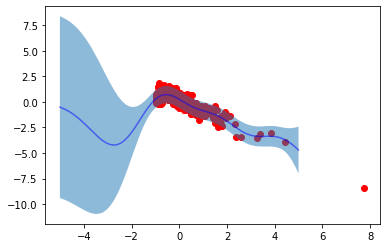

In [74]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(x_new, pred_f, c='b', alpha=0.5)
plt.fill_between(x_new[:, 0], (pred_f + 2 * np.sqrt(var_f))[:, 0], (pred_f - 2 * np.sqrt(var_f))[:, 0], alpha=0.5)
plt.show()

In [75]:
 - m_gpr.log_marginal_likelihood().numpy()

218.84750858357233

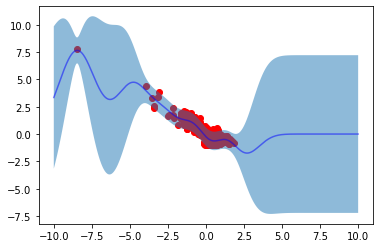

In [92]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(x_new, pred_f, c='b', alpha=0.5)
plt.fill_between(x_new[:, 0], (pred_f + 2 * np.sqrt(var_f))[:, 0], (pred_f - 2 * np.sqrt(var_f))[:, 0], alpha=0.5)
plt.show()

In [93]:
- m_gpr.log_marginal_likelihood().numpy()

217.66095511847294

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

tf.config.list_physical_devices('GPU')

2022-05-24 17:39:07.953504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 17:39:07.954158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 17:39:07.954198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-24 17:39:07.954232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-24 17:39:07.954265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

[]

In [98]:
from gpflow.base import Parameter
from gpflow.utilities import positive

tf.config.run_functions_eagerly(False)

# for i in range(500):
# x, y, weight = get_synthetic_dataset(
#     num_datasets=100,
#     sample_size=100,
#     func_string="mult_a",
#     noise="uniform"
# )
# x = (x - x.mean(axis=1)[:, None, :]) / x.std(axis=1)[:, None, :]
# y = (y - y.mean(axis=1)[:, None, :]) / y.std(axis=1)[:, None, :]

# input, output = x[0], y[0]

kernel_variance = 1.0
# Likelihood variance
kappa = np.random.uniform(
    low=1.0, high=100, size=[1]
)
# Kernel lengthscale
lamda = np.random.uniform(
    low=1.0, high=10, size=[2]
)

latent_dim = 1
num_inducing = 349

kernel_lengthscale = 1. / lamda
likelihood_variance = Parameter( 1. / (kappa ** 2), transform=positive(lower=1e-6))

print(f"Initial hyper: lengthscale - {kernel_lengthscale}, variance - {likelihood_variance.numpy()}")

sq_exp = gpflow.kernels.SquaredExponential()
sq_exp.variance.assign(kernel_variance)
    # lambda = 5 in this
sq_exp.lengthscales.assign(kernel_lengthscale[0])

m = gpflow.models.GPR(data=(input, output), kernel=sq_exp, mean_function=None)
m.likelihood.variance = likelihood_variance[0]
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=10000)
)
# found_lengthscales = [m.kernel.kernels[0].lengthscales.numpy(), m.kernel.kernels[1].lengthscales.numpy(), m.kernel.kernels[2].lengthscales.numpy()]
found_lengthscale = m.kernel.lengthscales.numpy()
found_lik_var = m.likelihood.variance.numpy()

X_mean_init = output - m.predict_f(input)[0]
# X_mean_init = tfp.distributions.Normal(loc=0, scale=1).sample([y.shape[0], latent_dim])
# X_mean_init = tf.cast(X_mean_init, dtype=default_float())
X_var_init = tf.ones((input.shape[0], latent_dim), dtype=default_float())
kernel = gpflow.kernels.SquaredExponential(lengthscales=[found_lengthscale] + [kernel_lengthscale[1]] * latent_dim)

m = PartObsBayesianGPLVM(
    data=output,
    in_data=input,
    kernel=kernel,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    num_inducing_variables=num_inducing,
)
m.likelihood.variance = Parameter( found_lik_var, transform=positive(lower=1e-6))

# Train only inducing variables
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train only x_var
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, True)
gpflow.utilities.set_trainable(m.inducing_variable, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train all the hyperparameters
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, False)
gpflow.utilities.set_trainable(m.inducing_variable, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train everything
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
gpflow.utilities.set_trainable(m.X_data_mean , True)
gpflow.utilities.set_trainable(m.X_data_var, True)
gpflow.utilities.set_trainable(m.inducing_variable, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

Initial hyper: lengthscale - [0.61883171 0.13313174], variance - [0.00054382]


In [ ]:
from gpflow.utilities import print_summary
print_summary(m)

╒══════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤══════════════════════════════════════╕
│ name                                     │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                │
╞══════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪══════════════════════════════════════╡
│ PartObsBayesianGPLVM.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 4.8897554654502314e-08               │
├──────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────────────────┤
│ PartObsBayesianGPLVM.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)     │ float64 │ [3.70035018e-05 5.05022419e-01]      │
├───────────────────────────────────────

In [44]:
- m.elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=454.35240666297375>

In [ ]:
obs_new = np.linspace(-20, 20, 4000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = m.predict_y(
    in_data_new=input,
    Xnew=Xnew,
)

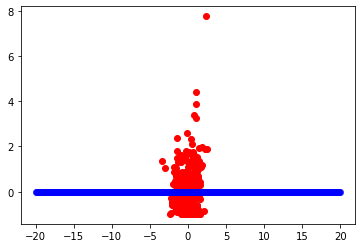

In [ ]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.scatter(obs_new, pred_f_mean, c='b', alpha=0.1)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()

In [38]:
-m.elbo().numpy()

687.4419320636074

In [22]:
-m.elbo().numpy()

-499.09120544465554

In [87]:
-945.981557225954 < -751.9391785862274

True

In [24]:
plt.scatter(x[0, :, 0], y[0, :, 0], c='r')
plt.scatter(x[0], pred_f_mean, c='b', alpha=0.5)
plt.ylim(-20, 20)
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [15]:
- m.elbo().numpy()

119.29262107485727

In [183]:
from gpflow.base import Parameter
from gpflow.utilities import positive

input_2 = np.random.normal(0, 1, size=input.shape)

num_inducing = 349

kernel_variance = 1.
kernel_lengthscale = 1. / 4
likelihood_variance = Parameter( 1. / (20 ** 2), transform=positive())

sq_exp = gpflow.kernels.SquaredExponential()
sq_exp.variance.assign(kernel_variance)
    # lambda = 5 in this
sq_exp.lengthscales.assign(kernel_lengthscale)

m_gpr = gpflow.models.GPR(data=(input_2, input), kernel=sq_exp, mean_function=None)
m_gpr.likelihood.variance = likelihood_variance
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m_gpr.training_loss, m_gpr.trainable_variables, options=dict(maxiter=10000)
)

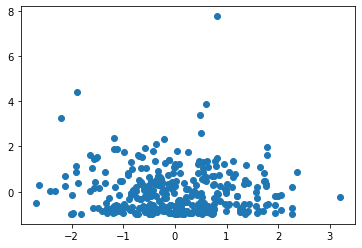

In [184]:
plt.scatter(input_2, input)
plt.show()

In [103]:
lamda = np.random.uniform(1, 10)
kernel_lengthscale = 1 / lamda

kappa = np.random.uniform(5, 50)
likelihood_variance = 1 / (kappa **2)

num_inducing = 349
latent_dim = 1
kernel_variance =  1.
# 0.0031185030135707325, 1.0383980119634681,  0.036263924352202444


tf.print(f"Kern_len: {kernel_lengthscale}, Like_var: {likelihood_variance}")

X_mean_init = tfp.distributions.Normal(loc=0, scale=1).sample([input.shape[0], latent_dim])
# X_mean_init = tf.cast(input, dtype=default_float())
# X_mean_init = tf.zeros((input.shape[0], latent_dim), dtype=default_float())
X_var_init = tf.ones((input.shape[0], latent_dim), dtype=default_float())  

x_prior_var = tf.ones((input.shape[0], latent_dim), dtype=default_float()) * kernel_lengthscale * 0.01
sq_exp = gpflow.kernels.SquaredExponential() 
sq_exp.variance.assign(kernel_variance)
sq_exp.lengthscales.assign(kernel_lengthscale)

kernel = sq_exp

m = gpflow.models.BayesianGPLVM(
    data=input,
    kernel=kernel,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    num_inducing_variables=num_inducing,
    X_prior_var=x_prior_var,
    jitter=1e-5
    )
m.likelihood.variance.assign(likelihood_variance)

Kern_len: 0.6793390315863401, Like_var: 0.0008288856022838077


<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-7.09622160325793>

In [104]:
# Train only inducing variables
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train only x_var
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, True)
gpflow.utilities.set_trainable(m.inducing_variable, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train all the hyperparameters
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, False)
gpflow.utilities.set_trainable(m.inducing_variable, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train everything
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
gpflow.utilities.set_trainable(m.X_data_mean , True)
gpflow.utilities.set_trainable(m.X_data_var, True)
gpflow.utilities.set_trainable(m.inducing_variable, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)
loss = - m.elbo()

2022-06-09 22:09:10.600779: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-09 22:09:10.601040: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fe5d7c09d00 = {1, 0} LB is not finite!


InvalidArgumentError: Graph execution error:

Detected at node 'VerifyFinite_1/CheckNumerics' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 707, in start
      self.io_loop.start()
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in dispatch_queue
      await self.process_one()
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 491, in process_one
      await dispatch(*args)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 398, in dispatch_shell
      await result
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 722, in execute_request
      reply_content = await reply_content
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 389, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2683797/2109503053.py", line 33, in <cell line: 33>
      opt_logs = opt.minimize(
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/optimizers/scipy.py", line 94, in minimize
      return scipy.optimize.minimize(
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_minimize.py", line 681, in minimize
      res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_lbfgsb_py.py", line 308, in _minimize_lbfgsb
      sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py", line 263, in _prepare_scalar_function
      sf = ScalarFunction(fun, x0, args, grad, hess,
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py", line 158, in __init__
      self._update_fun()
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
      self._update_fun_impl()
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
      self.f = fun_wrapped(self.x)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
      fx = fun(np.copy(x), *args)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py", line 76, in __call__
      self._compute_if_needed(x, *args)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py", line 70, in _compute_if_needed
      fg = self.fun(x, *args)
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/optimizers/scipy.py", line 136, in _eval
      loss, grad = _tf_eval(tf.convert_to_tensor(x))
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/optimizers/scipy.py", line 118, in _tf_eval
      if first_call:
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/optimizers/scipy.py", line 120, in _tf_eval
      loss, grads = _compute_loss_and_gradients(
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/optimizers/scipy.py", line 223, in _compute_loss_and_gradients
      loss = loss_closure()
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/models/training_mixins.py", line 60, in training_loss
      return self._training_loss()  # type: ignore
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/models/model.py", line 54, in _training_loss
      return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/models/gplvm.py", line 156, in maximum_log_likelihood_objective
      return self.elbo()
    File "/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflow/models/gplvm.py", line 189, in elbo
      tf.debugging.assert_all_finite(
Node: 'VerifyFinite_1/CheckNumerics'
LB is not finite! : Tensor had NaN values
	 [[{{node VerifyFinite_1/CheckNumerics}}]] [Op:__inference__tf_eval_257505]

In [ ]:
from gpflow.utilities import print_summary
print_summary(m)

╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤════════════════════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                  │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪════════════════════════╡
│ BayesianGPLVM.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 8.418192131911068      │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────────────┤
│ BayesianGPLVM.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.1891902281861994     │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────────────┤
│ BayesianGPLVM.likelihood.

In [ ]:
obs_new = np.linspace(-5, 5, 40)[:, None]
pred_y_mean, pred_y_var = m.predict_y(Xnew=obs_new)

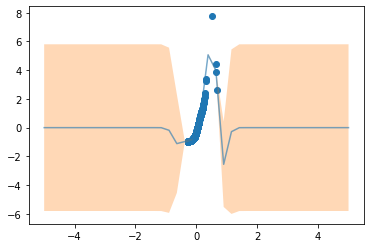

In [ ]:
ind = np.argsort(m.X_data_mean[:, 0])
x_values = np.take_along_axis(m.X_data_mean.numpy()[:, 0], ind, axis=0)
# pred_y_mean_new = np.take_along_axis(pred_y_mean.numpy()[:, 0], ind, axis=0) 
# pred_y_var_new = np.take_along_axis(pred_y_var.numpy()[:, 0], ind, axis=0)

plt.scatter(m.X_data_mean, input)
plt.plot(obs_new, pred_y_mean, alpha=0.6)
plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0], (pred_y_mean - 2 * np.sqrt(pred_y_var))[:, 0], alpha=0.3)
plt.show()

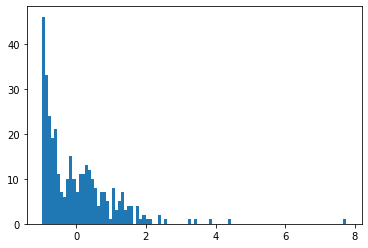

In [ ]:
plt.hist(input, bins=100)
plt.show()

In [ ]:
-m.elbo().numpy()

422.8804927548654

In [ ]:
407.47064394770905
391.04231501580705

In [98]:
from scipy.stats import norm
def ml_estimate(x):
    """
    Find the log likelihood.

    This doesn't make sense after I have normalised the data.
    """
    score = - np.sum( np.log(
            norm.pdf(x, loc=x.mean(), scale=x.std())

    ))
    print(norm.pdf(x, loc=x.mean(), scale=x.std()))
    return score

In [86]:
print( ml_estimate(x[2]), ml_estimate(y[2]), ml_estimate(np.random.normal(0, 1.5, 10000)))

[[0.2326027 ]
 [0.31852053]
 [0.13892459]
 ...
 [0.35506125]
 [0.39891987]
 [0.17203474]]
[[0.36215618]
 [0.38905551]
 [0.28767247]
 ...
 [0.3981433 ]
 [0.39889956]
 [0.258324  ]]
[0.17355695 0.26539336 0.1214141  ... 0.23633496 0.25741284 0.03818973]
14189.385332046726 14189.385332046728 18214.40122066285


In [8]:
tf.config.list_physical_devices('GPU')


[]

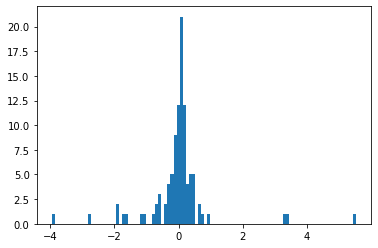

In [251]:
plt.hist(y[2], bins=100)
plt.show()

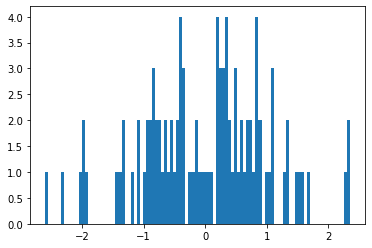

In [75]:
plt.hist(x[2], bins=100)
plt.show()

In [14]:
a = tf.Variable(1.0)
tf.debugging.check_numerics(a, message='')

b = tf.Variable(np.nan)
# try:
tf.debugging.check_numerics(b, message='Checking b')
# except Exception as e:
#   assert "Checking b : Tensor had NaN values" in e.message

c = tf.Variable(np.inf)
try:
  tf.debugging.check_numerics(c, message='Checking c')
except Exception as e:
  assert "Checking c : Tensor had Inf values" in e.message

InvalidArgumentError: Checking b : Tensor had NaN values [Op:CheckNumerics]

In [9]:
5541508.04182404 / 0.3

18471693.4727468

In [10]:
18471693.4727468

18471693.4727468